# Deploy BERT for Sentiment Analysis with Transformers by Hugging Face and FastAPI

> TL;DR Learn how to create a REST API for Sentiment Analysis using a pre-trained BERT model

- [Read the tutorial](https://www.curiousily.com/posts/deploy-bert-for-sentiment-analysis-as-rest-api-using-pytorch-transformers-by-hugging-face-and-fastapi/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/154jf65arX4cHGaGXl2_kJ1DT8FmF4Lhf)
- [Project on GitHub](https://github.com/curiousily/Deploy-BERT-for-Sentiment-Analysis-with-FastAPI)
- [`Getting Things Done with Pytorch` on GitHub](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

In this tutorial, you'll learn how to deploy a pre-trained BERT model as a REST API using FastAPI. Here are the steps:

- Initialize a project using Pipenv
- Create a project skeleton
- Add the pre-trained model and create an interface to abstract the inference logic
- Update the request handler function to return predictions using the model
- Start the server and send a test request

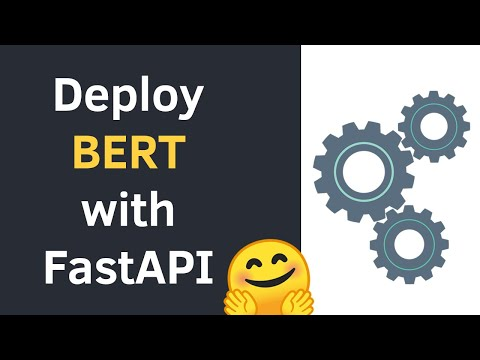

In [ ]:
#@title Watch the video tutorial

from IPython.display import YouTubeVideo
YouTubeVideo('K4rRyAIn0R0', width=720, height=420)


## Project setup

We'll manage our dependencies using [Pipenv](https://pipenv.pypa.io/en/latest/). Here's the complete Pipfile:

```python
[[source]]
name = "pypi"
url = "https://pypi.org/simple"
verify_ssl = true

[dev-packages]
black = "==19.10b0"
isort = "*"
flake8 = "*"
gdown = "*"

[packages]
fastapi = "*"
uvicorn = "*"
pydantic = "*"
torch = "*"
transformers = "*"

[requires]
python_version = "3.8"

[pipenv]
allow_prereleases = true
```

The backbone of our REST API will be:
- [FastAPI](https://fastapi.tiangolo.com/) - lets you easily set up a REST API (some say it might be fast, too)
- [Uvicorn](https://www.uvicorn.org/) - server that lets you do async programming with Python (pretty cool)
- [Pydantic](https://pydantic-docs.helpmanual.io/) - data validation by introducing types for our request and response data.

Some tools will help us write some better code (thanks to [Momchil Hardalov](https://github.com/mhardalov) for the configs):

- [Black](https://black.readthedocs.io/en/stable/) - code formatting
- [isort](https://timothycrosley.github.io/isort/) - imports sorting
- [flake8](https://flake8.pycqa.org/en/latest/) - check for code style (PEP 8) compliance




## Building a skeleton REST API

Let's start by creating a skeleton structure for our project. Your directory should look like this:

```bash
.
├── Pipfile
├── Pipfile.lock
└── sentiment_analyzer
    ├── api.py
```

We'll start by creating a dummy/stubbed response to test that everything is working end-to-end. Here are the contents of `api.py`:

```python
from typing import Dict

from fastapi import Depends, FastAPI
from pydantic import BaseModel

app = FastAPI()


class SentimentRequest(BaseModel):
    text: str


class SentimentResponse(BaseModel):

    probabilities: Dict[str, float]
    sentiment: str
    confidence: float


@app.post("/predict", response_model=SentimentResponse)
def predict(request: SentimentRequest):
    return SentimentResponse(
        sentiment="positive",
        confidence=0.98,
        probabilities=dict(negative=0.005, neutral=0.015, positive=0.98)
    )
```

Our API expects a text - the review for sentiment analysis. The response contains the sentiment, confidence (softmax output for the sentiment) and all probabilities for each sentiment.


## Adding our model

Here's the file structure of the complete project:

```bash
.
├── assets
│   └── model_state_dict.bin
├── bin
│   └── download_model
├── config.json
├── Pipfile
├── Pipfile.lock
└── sentiment_analyzer
    ├── api.py
    ├── classifier
    │   ├── model.py
    │   └── sentiment_classifier.py
```

We'll need the pre-trained model. We'll write the `download_model` script for that:

```python
#!/usr/bin/env python
import gdown

gdown.download(
    "https://drive.google.com/uc?id=1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA",
    "assets/model_state_dict.bin",
)
```

The model can be downloaded from my Google Drive. Let's get it:

```bash
python bin/download_model
```

Our pre-trained model is stored as a PyTorch state dict. We need to load it and use it to predict the text sentiment. 

Let's start with the config file `config.json`:

```javascript
{
    "BERT_MODEL": "bert-base-cased",
    "PRE_TRAINED_MODEL": "assets/model_state_dict.bin",
    "CLASS_NAMES": [
        "negative",
        "neutral",
        "positive"
    ],
    "MAX_SEQUENCE_LEN": 160
}
```

Next, we'll define the `sentiment_classifier.py`:

```python
import json

from torch import nn
from transformers import BertModel

with open("config.json") as json_file:
    config = json.load(json_file)


class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(config["BERT_MODEL"])
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)
```

This is the same model we've used for training. It just uses the config file.

Recall that BERT requires some special text preprocessing. We need a place to use the tokenizer from Hugging Face. We also need to do some massaging of the model outputs to convert them to our API response format.

The `Model` provides a nice abstraction (a Facade) to our classifier. It exposes a single `predict()` method and should be pretty generalizable if you want to use the same project structure as a template for your next deployment. The `model.py` file:

```python
import json

import torch
import torch.nn.functional as F
from transformers import BertTokenizer

from .sentiment_classifier import SentimentClassifier

with open("config.json") as json_file:
    config = json.load(json_file)


class Model:
    def __init__(self):

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.tokenizer = BertTokenizer.from_pretrained(config["BERT_MODEL"])

        classifier = SentimentClassifier(len(config["CLASS_NAMES"]))
        classifier.load_state_dict(
            torch.load(config["PRE_TRAINED_MODEL"], map_location=self.device)
        )
        classifier = classifier.eval()
        self.classifier = classifier.to(self.device)

    def predict(self, text):
        encoded_text = self.tokenizer.encode_plus(
            text,
            max_length=config["MAX_SEQUENCE_LEN"],
            add_special_tokens=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        input_ids = encoded_text["input_ids"].to(self.device)
        attention_mask = encoded_text["attention_mask"].to(self.device)

        with torch.no_grad():
            probabilities = F.softmax(self.classifier(input_ids, attention_mask), dim=1)
        confidence, predicted_class = torch.max(probabilities, dim=1)
        predicted_class = predicted_class.cpu().item()
        probabilities = probabilities.flatten().cpu().numpy().tolist()
        return (
            config["CLASS_NAMES"][predicted_class],
            confidence,
            dict(zip(config["CLASS_NAMES"], probabilities)),
        )


model = Model()


def get_model():
    return model
```

We'll do the inference on the GPU, if one is available. We return the name of the predicted sentiment, the confidence, and the probabilities for each sentiment.

But why don't we define all that logic in our request handler function? For this tutorial, this is an example of overengeneering. But in the real world, when you start testing your implementation, this will be such a nice bonus.

You see, mixing everything in the request handler logic will result in countless sleepless nights. When shit hits the fan (and it will) you'll wonder if your REST or model code is wrong. This way allows you to test them, separately.

The `get_model()` function ensures that we have a single instance of our Model (Singleton). We'll use it in our API handler.

## Putting everything together

Our request handler needs access to the model to return a prediction. We'll use the [Dependency Injection framework](https://fastapi.tiangolo.com/tutorial/dependencies/) provided by FastAPI to inject our model. Here's the new `predict` function:

```python
@app.post("/predict", response_model=SentimentResponse)
def predict(request: SentimentRequest, model: Model = Depends(get_model)):
    sentiment, confidence, probabilities = model.predict(request.text)
    return SentimentResponse(
        sentiment=sentiment, confidence=confidence, probabilities=probabilities
    )
```

The model gets injected by `Depends` and our Singleton function `get_model`. You can really appreciate the power of abstraction by looking at this!

But does it work?

## Testing the API

Let's fire up the server:

```bash
uvicorn sentiment_analyzer.api:app
```

This should take a couple of seconds to load everything and start the HTTP server.

```bash
http POST http://localhost:8000/predict text="This app is a total waste of time!"
```

Here's the response:

```javascript
{
    "confidence": 0.999885082244873,
    "probabilities": {
        "negative": 0.999885082244873,
        "neutral": 8.876612992025912e-05,
        "positive": 2.614063305372838e-05
    },
    "sentiment": "negative"
}
```

Let's try with a positive one:

```bash
http POST http://localhost:8000/predict text="OMG. I love how easy it is to stick to my schedule. Would recommend to everyone!"
```

```javascript
{
    "confidence": 0.999932050704956,
    "probabilities": {
        "negative": 1.834999602579046e-05,
        "neutral": 4.956663542543538e-05,
        "positive": 0.999932050704956
    },
    "sentiment": "positive"
}
```

Both results are on point. Feel free to tryout with some real reviews from the Play Store.

## Summary

You should now be a proud owner of ready to deploy (kind of) Sentiment Analysis REST API using BERT. Of course, you're missing lots of stuff to be production-ready - logging, monitoring, alerting, containerization, and much more. But hey, you did good!

- [Read the tutorial](https://www.curiousily.com/posts/deploy-bert-for-sentiment-analysis-as-rest-api-using-pytorch-transformers-by-hugging-face-and-fastapi/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/154jf65arX4cHGaGXl2_kJ1DT8FmF4Lhf)
- [Project on GitHub](https://github.com/curiousily/Deploy-BERT-for-Sentiment-Analysis-with-FastAPI)
- [`Getting Things Done with Pytorch` on GitHub](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Initialize a project using Pipenv
- Create a project skeleton
- Add the pre-trained model and create an interface to abstract the inference logic
- Update the request handler function to return predictions using the model
- Start the server and send a test request

Go on then, deploy and make your users happy!

## References

- [FastAPI Homepage](https://fastapi.tiangolo.com/)
- [fastAPI ML quickstart](https://github.com/cosmic-cortex/fastAPI-ML-quickstart)